In [ ]:
import numpy as np

import torch
import torch.nn as nn

from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
sns.set_style('whitegrid')

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 100
PATH = './model'

# Data loading, splitting and augmentation

In [ ]:
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(
    './cifar_10/', transform=transform, download=True)

test_dataset = torchvision.datasets.CIFAR10(
    './cifar_10/', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Extracting ./cifar_10/cifar-10-python.tar.gz to ./cifar_10/


# Model  

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, shortcut=None):
        super(BasicBlock, self).__init__()
        self.conv1 = self.conv(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = self.conv(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = shortcut
        if (stride != 1) or (in_channels != out_channels):
            self.shortcut = nn.Sequential(
                self.conv(in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels)
                )


    def conv(self, in_channels, out_channels, stride=1):
        return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                         stride=stride, padding=1, bias=False)

 
    def forward(self, x):
        residual = x
        x = self.bn1(self.conv1(x))
        x = self.relu(x)
        x = self.bn2(self.conv2(x))
        if self.shortcut:
            residual = self.shortcut(residual)
        x += residual
        x = self.relu(x)
        return x



class ResNet20(nn.Module):
    def __init__(self, block, n_classes=10):
        super(ResNet20, self).__init__()
        self.in_channels = 16
        self.conv = nn.Conv2d(3, 16, 3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, out_channels=16, stride=1)
        self.layer2 = self.make_layer(block, out_channels=32, stride=2)
        self.layer3 = self.make_layer(block, out_channels=64, stride=2)
        self.fc = nn.Linear(64, n_classes)


    def make_layer(self, block, out_channels, stride):
        layers = []
        layer = block(self.in_channels, out_channels, stride)
        layers.append(layer)
        self.in_channels = out_channels
        for i in range(2):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
         

    def forward(self, x):
        x = self.bn(self.conv(x))
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = F.avg_pool2d(x, x.shape[2:])
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Train Loop

In [ ]:
def fit_eval_epoch(model, criterion, dataloader, optimizer=None):
    avg_loss, corrects, total, avg_acc = 0, 0, 0, 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        if optimizer is not None:
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        else:
            model.eval()
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

        avg_loss += loss.item() / len(dataloader)
        _, preds = outputs.max(1)
        corrects += (preds == labels).sum().item()
        total += labels.size(0)
        avg_acc += corrects / total / len(dataloader)
    return avg_loss, avg_acc


def train(model, criterion, train_loader, test_loader, 
          optimizer, scheduler, epochs):
    history = []

    for epoch in range(epochs):
        avg_loss_tr, avg_acc_tr = fit_eval_epoch(
            model, criterion, train_loader, optimizer)
        avg_loss_val, avg_acc_val = fit_eval_epoch(
            model, criterion, test_loader)
        scheduler.step()
        history.append((avg_loss_tr, avg_acc_tr, avg_loss_val, avg_acc_val))
        loss_tr, acc_tr, loss_val, acc_val = zip(*history)

        clear_output(wait=True)
        print(f'* Epoch {epoch + 1}/{epochs}')  
        print(f'Loss train/val: {avg_loss_tr:.3f} | {avg_loss_val:.3f}\n'
              f'Accuracy train/val: {avg_acc_tr:.3f} | {avg_acc_val:.3f}')
        
        fig = plt.figure(figsize=(17.2, 5))

        plt.subplot(1, 2, 1)  
        plt.title('Loss') 
        plt.xlabel('epoch')
        plt.plot(loss_tr, label='train_loss')
        plt.plot(loss_val, label='val_loss')
        plt.legend()           

        plt.subplot(1, 2, 2)
        plt.title('Accuracy')
        plt.xlabel('epoch')
        plt.plot(acc_tr, label='train_acc')
        plt.plot(acc_val, label='val_acc') 
        plt.legend() 
        plt.show()
          
    return history

def test(model):
    model.eval()
    with torch.no_grad():
        corrects, total = 0, 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            corrects += (preds == labels).sum().item()
            total += labels.size(0)

    return corrects / total

In [ ]:
model = ResNet20(BasicBlock).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

* Epoch 200/200
Loss train/val: 0.019 | 0.256
Accuracy train/val: 0.997 | 0.931


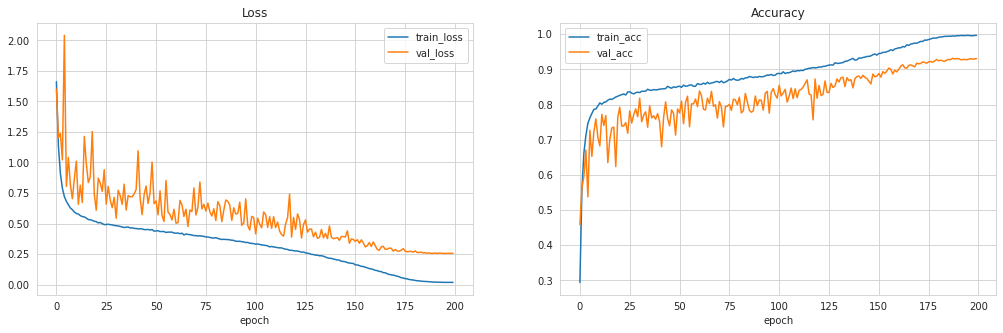

In [ ]:
history = train(model, criterion, train_loader, test_loader, 
                optimizer, scheduler, epochs=200)

In [ ]:
torch.save(model, './resnet20.pth')

In [ ]:
acc = test(model)
print(f'Accuracy (test): {acc:.2%}')

Accuracy (test): 93.02%


# Pruning

In [ ]:
def get_centroids_and_labels(layer, n_clusters):
    """
    Extracts kernel centroids and corresponding labels
    for 1st conv weights of provided layer (block).

    Parameters
    ----------
    layer : BasicBlock of ResNet20
        block to get 1st conv weights centroids from
    n_clusters : int
        number of clusters

    Returns
    -------
    torch.Tensor
        clusters' centers
    numpy.ndarray
        labels of each point
    """
    km, _ = get_kmeans(layer, n_clusters)
    size = list(layer.conv1.weight.shape[-3:])
    centroids = km.cluster_centers_.reshape(n_clusters, *size)
    centroids = torch.from_numpy(centroids).to(DEVICE)
    return centroids, km.labels_


def get_mask_from_centroid_labels_(labels):
    """
    Creates mask for unique labels

    Parameters
    ----------
    labels : numpy.ndarray
        labels of corresponding centroids (from get_centroids_and_labels)

    Returns
    -------
    numpy.ndarray
        mask of shape (len(labels), )
    """
    n = []
    for label in labels:
        if label not in n:
            n.append(label)
        else:
            n.append(None)
    size = len(labels)
    mask = np.zeros(size)
    for i in range(size):
        mask[i] = 0 if n[i] is None else 1

    return mask


def get_kmeans(layer, n_clusters):
    """
    Utilizes sklearn.cluster._kmeans.KMeans

    Parameters
    ----------
    layer : BasicBlock of ResNet20
        block to get 1st conv weights centroids from
    n_clusters : int
        number of clusters (number of centroids to generate)

    Returns
    -------
    sklearn.cluster._kmeans.KMeans
        KMeans class instance fitted on provided data
    numpy.ndarray
        1st conv weights flatten from dim 1
    """
    weights = layer.conv1.weight
    weights_flatten = weights.flatten(1).detach().cpu().numpy()
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(weights_flatten)
    return km, weights_flatten


def get_mask_from_closest(layer, n_clusters, mask4d=False):
    """
    Creates mask for conv1 filter weights of provided layer which are closest
    to centroid for each cluster (according to the euclidean distance).

    Parameters
    ----------
    layer : BasicBlock of ResNet20
        block to get 1st conv weights centroids from
    n_clusters : int
        number of clusters (number of centroids to generate)
    mask4d : bool, default=False
        whether to create a mask of size (layer.conv1.weight.shape)

    Returns
    -------
    numpy.ndarray (if mask4d=False)
        mask of size (layer.conv1.weight.shape[0])
    torch.Tensor (if mask4d=True)
        mask of size (layer.conv1.weight.shape)
    """
    km, weights_flatten = get_kmeans(layer, n_clusters)
    ids, dists = \
        pairwise_distances_argmin_min(km.cluster_centers_, weights_flatten)

    size = layer.conv1.weight.shape
    mask = np.arange(size[0])

    for i in mask:
        mask[i] = 1 if i in ids else 0

    if mask4d:
        mask = get_mask4d(mask, size)

    return mask


def get_mask4d(mask1d, size):
    """
    Creates a mask of provided size from 1-dimensional mask

    Parameters
    ----------
    mask1d : numpy.ndarray
        1-dimensional mask to transform
    size : torch.Size or tuple or list
        size of transformed mask

    Returns
    -------
    torch.Tensor
        mask of size (size)
    """
    assert mask1d.shape[0] == size[0]
    mask = torch.zeros(size)

    for i, n in enumerate(mask1d):
        mask[i].zero_() if n == 0 else mask[i].zero_().add_(1)

    return mask.to(DEVICE)


def drop_weights_(layer, mask):
    """
    Prunes (inplace) weights in accordance with provided mask

    Parameters
    ----------
    layer : BasicBlock of ResNet20
        block to prune 1st conv weights from
    mask : numpy.ndarray
        1-dimensional mask to prune weights in accordance with

    Returns
    -------
    None
    """
    n_channels_left = int(sum(mask))

    layer.conv1.weight = nn.Parameter(layer.conv1.weight[mask == 1, :, :, :])
    layer.conv1.out_channels = n_channels_left

    layer.bn1.num_features = n_channels_left
    layer.bn1.running_mean = layer.bn1.running_mean[mask == 1]
    layer.bn1.running_var = layer.bn1.running_var[mask == 1]
    layer.bn1.weight = nn.Parameter(layer.bn1.weight[mask == 1])
    layer.bn1.bias = nn.Parameter(layer.bn1.bias[mask == 1])

    layer.conv2.in_channels = n_channels_left
    layer.conv2.weight = nn.Parameter(layer.conv2.weight[:, mask == 1, :, :])

    return None


def prune_replace(layer, n_clusters, replace_weights=True):
    """
    Prunes (inplace) weights which are not in the most closest to centroid for each cluster,
    and, if replace_weights=True, replaces the closest ones with corresponding centroids.

    Parameters
    ----------
    layer : BasicBlock of ResNet20
        block to prune 1st conv weights from
    n_clusters : int
        number of clusters (number of centroids to generate)
    replace_weights : bool, default=True
        whether to replace weights with centroids of corresponding clusters

    Returns
    -------
    None
    """
    centroids, labels = get_centroids_and_labels(layer, n_clusters)
    mask = get_mask_from_centroid_labels_(labels)

    if replace_weights:
        for i, label in enumerate(labels):
            layer.conv1.weight.data[i] = centroids[label]

    drop_weights_(layer, mask)

    return None

In [ ]:
resnet20 = torch.load('./resnet20.pth')

## 1st block

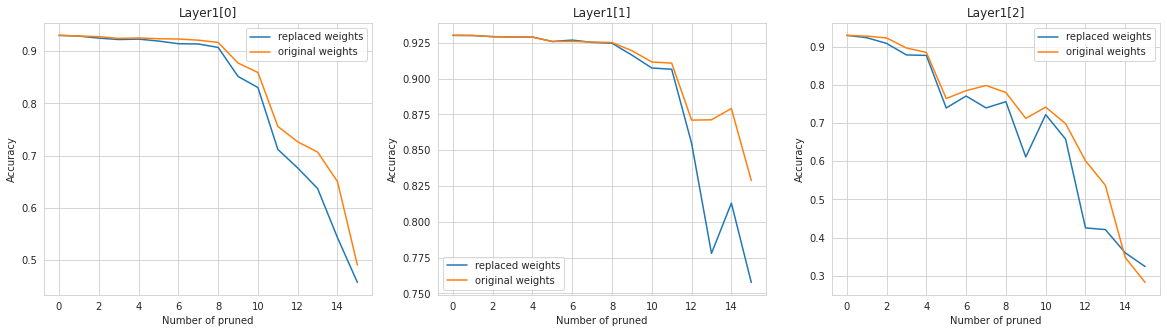

In [ ]:
n_channels = 16

plt.figure(figsize=(20, 5))
for j in range(3):
    accs1, accs2 = [], []
    for i in range(n_channels):
        model1 = deepcopy(resnet20)
        block = model1.layer1[j]
        prune_replace(block, n_channels - i)
        acc1 = test(model1)
        accs1.append(acc1)

        model2 = deepcopy(resnet20)
        block = model2.layer1[j]
        prune_replace(block, n_channels - i, replace_weights=False)
        acc2 = test(model2)
        accs2.append(acc2)    

    plt.subplot(1, 3, j+1)
    plt.title(f'Layer1[{j}]') 
    plt.xlabel('Number of pruned')
    plt.ylabel('Accuracy')
    plt.plot(np.arange(n_channels), accs1, label='replaced weights')
    plt.plot(np.arange(n_channels), accs2, label='original weights')
    plt.legend()  
    
plt.show()

## 2nd block

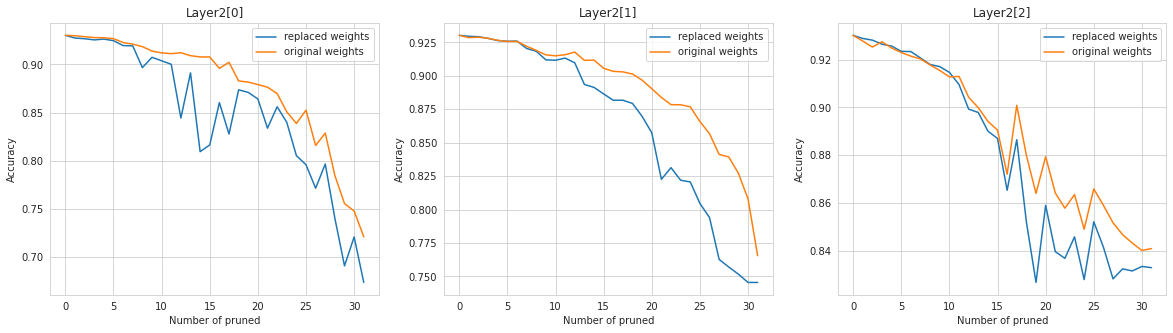

In [ ]:
n_channels = 32

plt.figure(figsize=(20, 5))
for j in range(3):
    accs1, accs2 = [], []
    for i in range(n_channels):
        model1 = deepcopy(resnet20)
        block = model1.layer2[j]
        prune_replace(block, n_channels - i)
        acc1 = test(model1)
        accs1.append(acc1)

        model2 = deepcopy(resnet20)
        block = model2.layer2[j]
        prune_replace(block, n_channels - i, replace_weights=False)
        acc2 = test(model2)
        accs2.append(acc2)    

    plt.subplot(1, 3, j+1)
    plt.title(f'Layer2[{j}]') 
    plt.xlabel('Number of pruned')
    plt.ylabel('Accuracy')
    plt.plot(np.arange(n_channels), accs1, label='replaced weights')
    plt.plot(np.arange(n_channels), accs2, label='original weights')
    plt.legend()  
    
plt.show()

## 3rd block

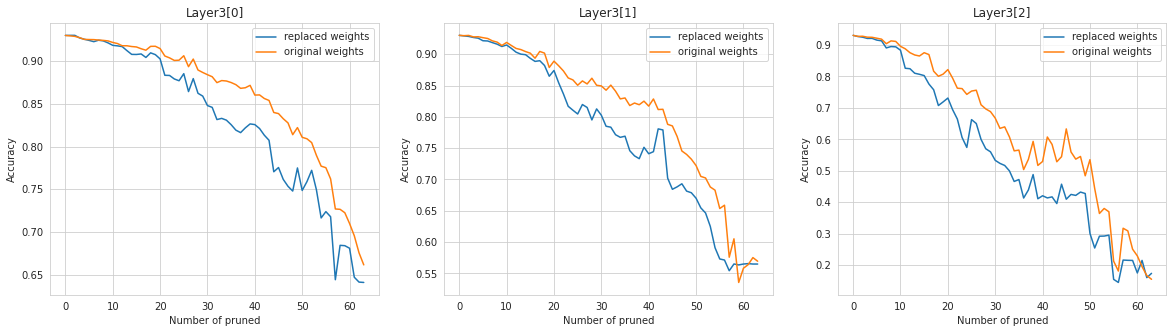

In [ ]:
n_channels = 64

plt.figure(figsize=(20, 5))
for j in range(3):
    accs1, accs2 = [], []
    for i in range(n_channels):
        model1 = deepcopy(resnet20)
        block = model1.layer3[j]
        prune_replace(block, n_channels - i)
        acc1 = test(model1)
        accs1.append(acc1)

        model2 = deepcopy(resnet20)
        block = model2.layer3[j]
        prune_replace(block, n_channels - i, replace_weights=False)
        acc2 = test(model2)
        accs2.append(acc2)    

    plt.subplot(1, 3, j+1)
    plt.title(f'Layer3[{j}]') 
    plt.xlabel('Number of pruned')
    plt.ylabel('Accuracy')
    plt.plot(np.arange(n_channels), accs1, label='replaced weights')
    plt.plot(np.arange(n_channels), accs2, label='original weights')
    plt.legend()  
    
plt.show()

В настоящей работе реализована архитектура ResNet20 вместе с процедурой обучения на наборе данных CIFAR10 (точность (accuracy) модели - 93.02%), а также метод прунинга (filter-level pruning) на полученной обученной модели.

Для реализации прунинга была проведена кластеризация (k-means++) сверток, представляющих отдельные слои. Каждая исходная свертка в соответствующем слое заменялась на центроид кластера, к которому она была отнесена, при этом прочие представители каждого кластера удалялись.  
С учетом специфической структуры используемой сети (необходимость наличия полного количества каналов, чтобы выполнить операцию сложения с "остатком" в каждом блоке) мы применяли прунинг только к первым сверточным слоям каждого блока (BasicBlock). 
Дополнительно, вместо стратегии замены весов на центроиды соответствующих кластеров, мы использовали идею оставить только те веса, которые оказались наиболее близки к центроидам своих кластеров (без замены). Это позволило улучшить результаты (см. ниже), однако стоит отметить, что наша реализация стратегии замены на центроиды имеет пробелы и еще требует существенной доработки, поэтому мы пока не можем позволить себе сделать вполне обоснованные выводы.



